Technical Analysis libraries:   
* pip install TA-Lib         ---- 150 + indicators, supports work with pandasd. TA-Lib is the golden standard, but it is not the easiest one to understand and dive deep into.
* pip install --upgrade ta   ---- 42 indicators, supports work with pandas. ( Can run all 42 indicators in one line of code).  
* pip install pandas_ta      ---- 130+ indicators, supports work with pandas.   

*** Read more here : https://medium.com/geekculture/top-4-python-libraries-for-technical-analysis-db4f1ea87e09

Portfolio Assessment libraries:
* pip install pyfolio -- Portfolio analysis (seems like it is not supported anymore)

In [32]:
import requests as r
import pandas as pd 
import numpy as np
import json as j
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf
import seaborn as sns
from scipy.stats import geom

KEY = '4239092CFMPXI6YI' # alphavantage.co API key
STOCK_LIST = ['MSFT','TSLA','BABA','VZ','AAPL', 'NEM'] # 

### Getting data from aplha vantage API and storing it in csv files

Daily data:

In [2]:
def get_daily_adjusted_data(ticker,key):
    url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={key}&outputsize=full'
    response = r.get(url_json)
    j_response = response.json()
    formated_response = j.dumps(j_response, indent=4)
    return formated_response

In [3]:
# for ticker in STOCK_LIST:
#     data = get_daily_adjusted_data(ticker,KEY)
#     data = j.loads(data)
#     data = data['Time Series (60min)']
#     df = pd.DataFrame(data)
#     df = df.transpose()
#     df.to_csv(f'..\P1-Indicators-Chart-Analysis\Data\Daily\{ticker}-hourly.csv')

Hourly data: (for the last 2 years)

In [4]:
def get_intraday_extended_data(ticker,key,interval='60min',slice='year1month1'):
    if slice == '2yearData':
        months = ['1','2','3','4','5','6','7','8','9','10','11','12']
        years = ['1','2']
        with open(f'..\P1-Indicators-Chart-Analysis\Data\Hourly\{ticker}-2years-hourly.csv', 'w') as f:
            for year in years:
                for month in months:
                    slice = f'year{year}month{month}'
                    url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={ticker}&interval={interval}&slice={slice}&apikey={key}'
                    response = r.get(url_json)
                    f.write(response.text)
                    time.sleep(13) # API limit is 5 calls per minute
    else:
        url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={ticker}&interval={interval}&slice={slice}&apikey={key}'
        response = r.get(url_json)
        with open(f'..\P1-Indicators-Chart-Analysis\Data\Hourly\{ticker}-30days-hourly.csv', 'w') as f:
            f.write(response.text)

In [5]:
# for ticker in STOCK_LIST:
#     get_intraday_extended_data(ticker,KEY,slice='2yearData')

### Data Visualization and Chart Analysis

In [6]:
# load data from csvs
aapl_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\AAPL-daily.csv', index_col=0,parse_dates=True)
baba_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\BABA-daily.csv', index_col=0,parse_dates=True)
msft_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\MSFT-daily.csv', index_col=0,parse_dates=True)
nem_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\NEM-daily.csv', index_col=0,parse_dates=True)
tsla_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\TSLA-daily.csv', index_col=0,parse_dates=True)
vz_d_source= pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\VZ-daily.csv', index_col=0,parse_dates=True)

aapl_d_source.index.rename('Date', inplace=True)
baba_d_source.index.rename('Date', inplace=True)
msft_d_source.index.rename('Date', inplace=True)
nem_d_source.index.rename('Date', inplace=True)
tsla_d_source.index.rename('Date', inplace=True)
vz_d_source.index.rename('Date', inplace=True)

In [7]:
aapl_d_source.head(2)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2023-03-10,150.210,150.940,147.6096,148.50,148.50,68572400,0.0,1.0
2023-03-09,153.559,154.535,150.2250,150.59,150.59,53833582,0.0,1.0


Check if data is actually adjusted for splits and dividends as it should be per the API documentation:

In [8]:
aapl_d_source['8. split coefficient'].value_counts()

1.000000    5873
2.000000       2
4.000000       1
7.000007       1
Name: 8. split coefficient, dtype: int64

In [9]:
splits = aapl_d_source[~aapl_d_source['8. split coefficient'].isin([1])].copy(deep=True)
splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
splits

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2020-08-31,127.58,131.00,126.00,129.04,126.935683,223505733,0.0,4
2014-06-09,92.70,93.88,91.75,93.70,20.831391,75414997,0.0,7
2005-02-28,44.68,45.14,43.96,44.86,1.361730,11635900,0.0,2
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2


Quick check online confirms that these are the dates of the splits for AAPL stock.  
Let's see if the next day's open price is adjusted for the split.

In [10]:
aapl_d_source.loc['2000-06-19':'2000-06-26':-1]
# aapl_d_source.loc['2005-02-24':'2005-03-01':-1]
# aapl_d_source.loc['2014-06-06':'2014-06-11':-1]
# aapl_d_source.loc['2020-08-27':'2020-09-02':-1]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2000-06-19,90.56,97.87,89.81,96.62,0.733228,3517900,0.0,1.0
2000-06-20,98.50,103.94,98.37,101.25,0.768364,4476700,0.0,1.0
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2.0
2000-06-22,55.75,57.63,53.56,53.75,0.815794,8352000,0.0,1.0
2000-06-23,53.78,54.63,50.81,51.69,0.784528,3660100,0.0,1.0
2000-06-26,52.50,54.75,52.13,54.13,0.821561,3309900,0.0,1.0


As we can see the column "5. adjusted close" indicates the adjusted close price for the split. Great.   
However to use some of the indicators we need to use the high, low, open and close prices.

In [11]:
for split in splits.index:
    aapl_d_source.loc[split-timedelta(days=1):,'1. open'] = aapl_d_source.loc[split:,'1. open'] / splits.loc[split,'8. split coefficient']
    aapl_d_source.loc[split-timedelta(days=1):,'2. high'] = aapl_d_source.loc[split:,'2. high'] / splits.loc[split,'8. split coefficient']
    aapl_d_source.loc[split-timedelta(days=1):,'3. low'] = aapl_d_source.loc[split:,'3. low'] / splits.loc[split,'8. split coefficient']
    aapl_d_source.loc[split-timedelta(days=1):,'4. close'] = aapl_d_source.loc[split:,'4. close'] / splits.loc[split,'8. split coefficient']    

Adjusting for the splits:

In [12]:
aapl_d_source.loc['2000-06-19':'2000-06-26':-1]
# aapl_d_source.loc['2005-02-24':'2005-03-01':-1]
# aapl_d_source.loc['2014-06-06':'2014-06-11':-1]
# aapl_d_source.loc['2020-08-27':'2020-09-02':-1]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2000-06-19,0.808571,0.873839,0.801875,0.862679,0.733228,3517900,0.0,1.0
2000-06-20,0.879464,0.928036,0.878304,0.904018,0.768364,4476700,0.0,1.0
2000-06-21,0.901786,1.016786,0.898393,0.993393,0.844327,4375000,0.0,2.0
2000-06-22,0.995536,1.029107,0.956429,0.959821,0.815794,8352000,0.0,1.0
2000-06-23,0.960357,0.975536,0.907321,0.923036,0.784528,3660100,0.0,1.0
2000-06-26,0.937500,0.977679,0.930893,0.966607,0.821561,3309900,0.0,1.0


* Saving function to reuse later.

In [13]:
def adjust_price_for_splits(df):
    splits = df[~df['8. split coefficient'].isin([1])].copy(deep=True)
    splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
    for split in splits.index:
        df.loc[split-timedelta(days=1):,'1. open'] = df.loc[split:,'1. open'] / splits.loc[split,'8. split coefficient']
        df.loc[split-timedelta(days=1):,'2. high'] = df.loc[split:,'2. high'] / splits.loc[split,'8. split coefficient']
        df.loc[split-timedelta(days=1):,'3. low'] = df.loc[split:,'3. low'] / splits.loc[split,'8. split coefficient']
        df.loc[split-timedelta(days=1):,'4. close'] = df.loc[split:,'4. close'] / splits.loc[split,'8. split coefficient']  
    df = df.rename(columns={'1. open':'Open', '2. high':'High', '3. low':'Low', '4. close':'Close', '6. volume':'Volume'})
    df = df[::-1]
    return df, splits

In [14]:
aapl_d, aapl_splits = adjust_price_for_splits(aapl_d_source)
baba_d, baba_splits = adjust_price_for_splits(baba_d_source)
msft_d, msft_splits = adjust_price_for_splits(msft_d_source)
nem_d, nem_splits = adjust_price_for_splits(nem_d_source)
tsla_d, tsla_splits = adjust_price_for_splits(tsla_d_source)
vz_d, vz_splits = adjust_price_for_splits(vz_d_source)

aapl_d.name = 'AAPL'
baba_d.name = 'BABA'
msft_d.name = 'MSFT'
nem_d.name = 'NEM'
tsla_d.name = 'TSLA'
vz_d.name = 'VZ'
# For Easy access to the data and manipulation
growth = [aapl_d, baba_d, msft_d, tsla_d]
value = [nem_d, vz_d]
all_stocks = [aapl_d, baba_d, msft_d, nem_d, tsla_d, vz_d]

#### Plotting stock price and volume for the last 2 years

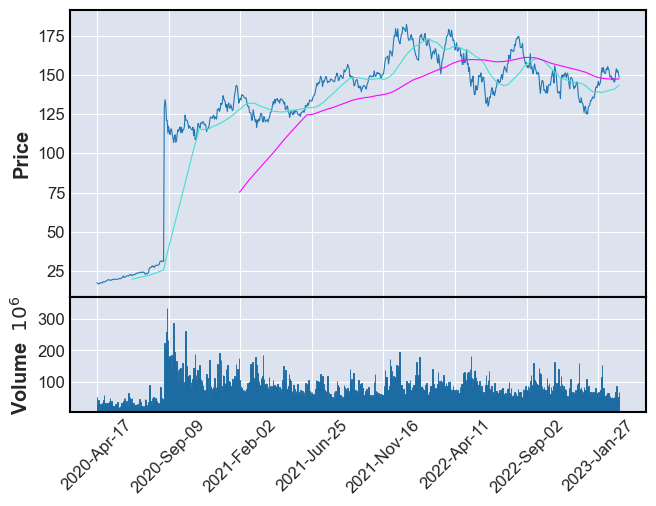

In [15]:
mpf.plot(aapl_d[-730::], type='line',  volume=True,  mav=(50, 200)) # quick plot

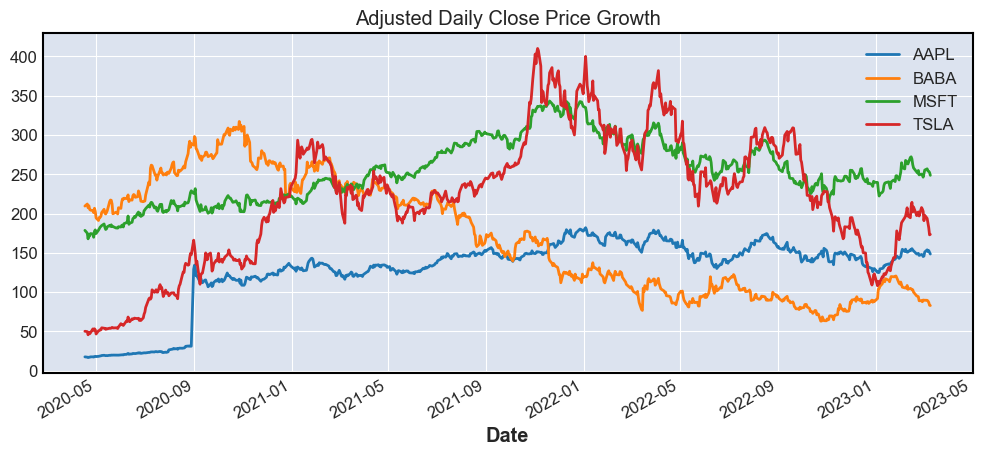

In [16]:
aapl_d['Close'][-730:].plot(figsize=(12,5),label='AAPL', title='Adjusted Daily Close Price Growth')
baba_d['Close'][-730:].plot(label='BABA')
msft_d['Close'][-730:].plot(label='MSFT')
tsla_d['Close'][-730:].plot(label='TSLA')
plt.legend()

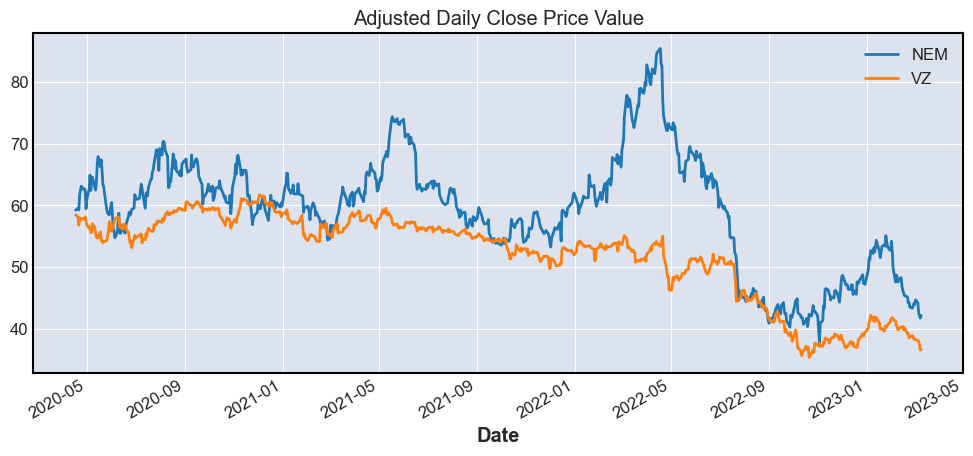

In [17]:
nem_d['Close'][-730:].plot(label='NEM',figsize=(12,5), title='Adjusted Daily Close Price Value')
vz_d['Close'][-730:].plot(label='VZ')
plt.legend()

In [18]:
for stock in all_stocks:
    stock['MA30'] = stock['Close'].rolling(30).mean()
    stock['MA120'] = stock['Close'].rolling(120).mean()

<Axes: title={'center': 'APPL MA30 and MA150'}, xlabel='Date'>

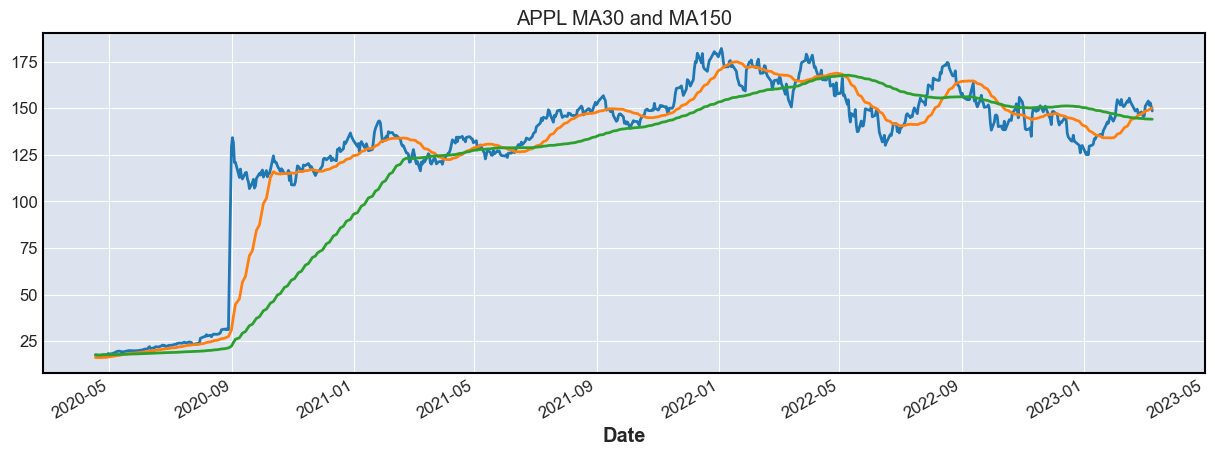

In [19]:
aapl_d['Close'][-730:].plot(figsize=(15,5),label='AAPL', title='APPL MA30 and MA150')
aapl_d['MA30'][-730:].plot(label='MA30')
aapl_d['MA120'][-730:].plot(label='MA120')

#### Conditional probability.
Determining probability of the stock moving up or down based on previous day movement (+2%, +3%, +4%, +5%, +6%) and (-2%, -3%,-4%, -5%, -6%) for different time frames


In [20]:
for stock in all_stocks:
    stock['Daily Return'] = stock['Close'].pct_change() # Calculate the daily returns for each stock into a new column called 'Daily Return'
    conditions = [stock['Daily Return'] < -0.05, 
                stock['Daily Return'].between(-0.05, -0.04, inclusive='left'), 
                stock['Daily Return'].between(-0.04, -0.03, inclusive='left'), 
                stock['Daily Return'].between(-0.03, -0.02, inclusive='left'), 
                stock['Daily Return'].between(-0.02, -0.01, inclusive='left'), 
                stock['Daily Return'].between(-0.01, 0, inclusive='left'), 
                stock['Daily Return'].between(0, 0.01, inclusive='left'), 
                stock['Daily Return'].between(0.01, 0.02, inclusive='left'), 
                stock['Daily Return'].between(0.02, 0.03, inclusive='left'), 
                stock['Daily Return'].between(0.03, 0.04, inclusive='left'), 
                stock['Daily Return'].between(0.04, 0.05, inclusive='left'), 
                stock['Daily Return'] >= 0.05]
    values = [-5, -4, -3, -2, -1, 0, 0, 1, 2, 3, 4, 5]
    stock['return bucket'] = np.select(conditions, values)
    stock = stock[~stock['Daily Return'].isnull()] 
for stock in all_stocks:
    # create column called 'UP or DOWN' to indicate whether the stock price increased or decreased and populate it based on the 'return bucket' column
    conditions = [stock['return bucket'].isin([ -1, -2, -3, -4, -5]),
                  stock['return bucket'].isin([0, 1, 2, 3, 4, 5])]
    values = [-1, 1]
    stock['UP or DOWN'] = np.select(conditions, values)

In [21]:
# calculate probability of each return bucket
aapl_d['return bucket'].value_counts(normalize=True)

 0    0.439680
 1    0.147354
-1    0.116386
 2    0.068913
-2    0.067381
 3    0.038455
-3    0.030968
 5    0.028076
-5    0.022290
 4    0.021099
-4    0.019398
Name: return bucket, dtype: float64

* Here is a function which can give us probabilities for stock to go up or down based on previous day percentage change.

In [22]:
def calc_proba_price_change_based(stock_df, percentChange, days, print_proba=False):
    '''Calculates probabilities of a stock to go up or down next day, based on percent change in price
    '''
    df = stock_df.copy(deep=True)[-days:]
    # shift return bucket column up by one row to match the previous day's return bucket
    df['previous_day_return_bucket'] = df['return bucket'].rolling(2).apply(lambda x: x[0])
    # calculate probability of up or down given previous day's return bucket
    proba_df = df[['previous_day_return_bucket','UP or DOWN']].value_counts(normalize=True).to_frame().rename(columns={0:'Probability'}).pivot_table(columns='previous_day_return_bucket', index='UP or DOWN', values='Probability')
    percentChange = float(percentChange)
    final_df = proba_df[percentChange].rename(index={-1.0:'Negative', 1.0:'Positive'})
    for r in final_df.index:
        if print_proba:
            print(f'Probability of {r} is {round(final_df[r]*100,2)}%')
    return proba_df

In [23]:
calc_proba_price_change_based(tsla_d, percentChange=0, days=365, print_proba=True)

Probability of Negative is 9.89%
Probability of Positive is 15.93%


previous_day_return_bucket,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0
UP or DOWN,,,,,,,,,,,
-1,0.030220,0.016484,0.019231,0.035714,0.032967,0.098901,0.041209,0.021978,0.021978,0.008242,0.024725
1,0.093407,0.035714,0.024725,0.030220,0.035714,0.159341,0.068681,0.035714,0.057692,0.032967,0.074176


* Calculating colinearity between the stocks

In [24]:
# Make a comparison table for all 5 stocks you entered above. This should give collinearity.
def compare_stocks(all_stocks, days):
    colinearity_df = pd.DataFrame()
    for stock in all_stocks:
        df = calc_proba_price_change_based(stock, percentChange=0, days=days, print_proba=False)
        df = df.iloc[1].to_frame().T
        df.index = [stock.name] * len(df)
        colinearity_df = pd.concat([colinearity_df, df], axis=0)
    sns.heatmap(colinearity_df.T.corr(), annot=True, cmap='coolwarm')
    return colinearity_df

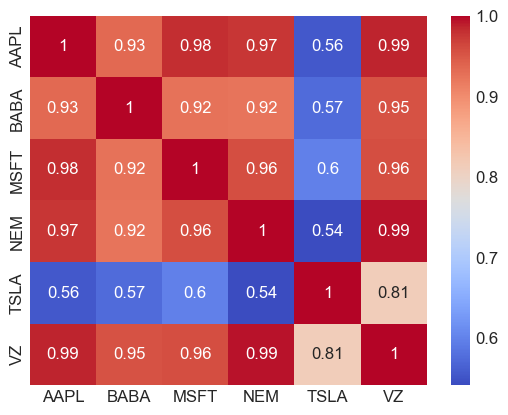

In [25]:
col_df = compare_stocks(all_stocks, days=150)

* Function to calculate the probalility of trend going UP or DOWN based on the previous movement over last few days.   
We can use Geometric distribution and PMF - Probability Mass Function from SciPy module to calculate the probability of the stock going up or down based on the previous movement.

In [33]:
aapl_d['UP or DOWN'].value_counts(normalize=True).loc[1] # probability of AAPL going up on any day

0.7435766547558278

In [79]:
def proba_up_down(stock_df, cont_days, period_days, direction):
    '''Calculates probability of a stock to go on specified direction for a given number of days in a row.
    '''
    if direction == 'up':
        direction_int = 1
    if direction == 'down':
        direction_int = -1
    df = stock_df.copy(deep=True)[-period_days:]
    proba = geom.pmf(cont_days, df['UP or DOWN'].value_counts(normalize=True).loc[direction_int])
    print(f'Probability of {stock_df.name} going "{direction.upper()}" for {cont_days} days in a row is {round(proba*100,3)}%')
     


In [96]:
proba_up_down(aapl_d, cont_days=5, period_days=365*20, direction='up')

Probability of AAPL going "UP" for 5 days in a row is 0.321%


* Screen through all Nasdaq and NYSE stocks and find the top 10 trending stocks (rank based on percentage change for the day). 	Only for 1 last day.